In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import time
%matplotlib inline

os.chdir('..\..\..\..')

# from input_configuration import base_year
import toml
config = toml.load(os.path.join(os.getcwd(), 'configuration/input_configuration.toml'))

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [2]:
# Create timestamp to show when this summary was run
print('Summary run: ' + time.strftime("%a, %d %b %Y %H:%M"))

Summary run: Tue, 06 Aug 2024 06:45


In [3]:
working_dir = r'outputs/agg/dash'
pd.options.display.float_format = '{:0,.0f}'.format
format_percent = "{:,.1%}".format

# Workers by County

In [4]:
df_wfh = pd.read_csv(os.path.join(working_dir,'wfh_county.csv'))
df_wfh_survey = pd.read_csv(os.path.join(working_dir,'survey','wfh_county.csv'))

# Total Workers by County
df_tot = pd.read_csv(os.path.join(working_dir,'pptyp_county.csv'))
df_tot = df_tot[df_tot['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df_tot = df_tot.groupby('person_county').sum()[['psexpfac']].reset_index()
total_nonwfh_workers = df_tot.sum()['psexpfac']

df_tot_survey = pd.read_csv(os.path.join(working_dir,'survey','pptyp_county.csv'))
df_tot_survey = df_tot_survey[df_tot_survey['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df_tot_survey = df_tot_survey.groupby('person_county').sum()[['psexpfac']].reset_index()
total_nonwfh_workers_survey = df_tot_survey.sum()['psexpfac']

df = df_wfh.merge(df_tot, on='person_county')
df.index = df['person_county']
df.drop('person_county', axis=1,inplace=True)
df.columns = ['WFH Workers', 'Total Workers']
df.loc['Region'] = df.sum(axis=0)
df['% WFH Workers'] = (df['WFH Workers']/df['Total Workers']).apply(format_percent)
df

,WFH Workers,Total Workers,% WFH Workers
person_county,,,
King,"165,432","1,217,019",13.6%
Kitsap,"18,224","118,557",15.4%
Pierce,"61,178","425,752",14.4%
Snohomish,"64,564","420,828",15.3%
Region,"309,398","2,182,156",14.2%


# Tour Rate for Work-at-Home Workers

In [5]:
df_tours = pd.read_csv(os.path.join(working_dir,'work_from_home_tours.csv'))
total_wfh_workers = df_wfh.psexpfac.sum()
df = df_tours.groupby('pdpurp').sum()[['toexpfac']].reset_index()
df['tour_rate'] = df['toexpfac']/total_wfh_workers
df

df_tours_survey = pd.read_csv(os.path.join(working_dir,'survey','work_from_home_tours.csv'))
total_wfh_workers_survey = df_wfh.psexpfac.sum()
df_survey = df_tours_survey.groupby('pdpurp').sum()[['toexpfac']].reset_index()
df_survey['tour_rate'] = df_survey['toexpfac']/total_wfh_workers_survey
df = df.merge(df_survey,on='pdpurp',suffixes=['_model','_survey'])
df.rename(columns={'toexpfac_model': 'tours_model', 'toexpfac_survey': 'tours_survey'}, inplace=True)
df['tours_survey'] = df['tours_survey'].astype('int')
df[['pdpurp','tours_model','tours_survey','tour_rate_model','tour_rate_survey']]
for col in ['tour_rate_model','tour_rate_survey']:
    df[col] = df[col].apply("{:,.2f}".format)
df

,pdpurp,tours_model,tour_rate_model,tours_survey,tour_rate_survey
0,Escort,"66,705",0.22,101739,0.33
1,Meal,"67,130",0.22,32403,0.10
2,Personal Business,"17,269",0.06,34735,0.11
3,School,"1,810",0.01,1466,0.00
4,Shop,"42,221",0.14,49070,0.16
5,Social,"117,783",0.38,104941,0.34
6,Work,799,0.00,18935,0.06


### Tour Rates for Workers that do NOT WF

In [6]:
# Tour Rates by purpose by worker type
df = pd.read_csv(os.path.join(working_dir,'non_wfh_tours.csv'))
df = df[df['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df = df.groupby('pdpurp').sum().reset_index()
df['tour_rate'] = df['toexpfac']/df_tot.sum()[['psexpfac']].values[0]

df_survey = pd.read_csv(os.path.join(working_dir,'survey','non_wfh_tours.csv'))
df_survey = df_survey[df_survey['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df_survey = df_survey.groupby('pdpurp').sum().reset_index()
df_survey['tour_rate'] = df_survey['toexpfac']/df_tot_survey.sum()[['psexpfac']].values[0]

df = df.merge(df_survey, on='pdpurp', suffixes=['_model','_survey'])
df.rename(columns={'toexpfac_model':'total_tours_model','toexpfac_survey':'total_tours_survey'},
         inplace=True)
# df[['pdpurp','total_tours_model','total_tours_survey','tour_rate_model','tour_rate_survey']]
for col in ['tour_rate_model','tour_rate_survey']:
    df[col] = df[col].apply("{:,.2f}".format)
df

,pdpurp,total_tours_model,tour_rate_model,total_tours_survey,tour_rate_survey
0,Escort,"214,798",0.10,"191,099",0.09
1,Meal,"400,439",0.18,"237,886",0.11
2,Personal Business,"111,435",0.05,"104,464",0.05
3,School,"2,004",0.00,"38,304",0.02
4,Shop,"189,166",0.09,"174,052",0.08
5,Social,"464,952",0.21,"493,724",0.24
6,Work,"1,356,013",0.62,"1,281,600",0.62


### Tour Rates for Non-Workers

In [7]:
df = pd.read_csv(os.path.join(working_dir,'non_wfh_tours.csv'))
df = df[-df['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df = df.groupby('pdpurp').sum().reset_index()
df['tour_rate'] = df['toexpfac']/df_tot_survey.sum()[['psexpfac']].values[0]


df_survey = pd.read_csv(os.path.join(working_dir,'survey','non_wfh_tours.csv'))
df_survey = df_survey[-df_survey['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df_survey = df_survey.groupby('pdpurp').sum().reset_index()
df_survey['tour_rate'] = df_survey['toexpfac']/df_tot_survey.sum()[['psexpfac']].values[0]

df = df.merge(df_survey, on='pdpurp', suffixes=['_model','_survey'])
df.rename(columns={'toexpfac_model':'total_tours_model','toexpfac_survey':'total_tours_survey'},
         inplace=True)
for col in ['tour_rate_model','tour_rate_survey']:
    df[col] = df[col].apply("{:,.2f}".format)
df

,pdpurp,total_tours_model,tour_rate_model,total_tours_survey,tour_rate_survey
0,Escort,"498,283",0.24,"367,605",0.18
1,Meal,"187,410",0.09,"127,871",0.06
2,Personal Business,"229,108",0.11,"167,384",0.08
3,School,"573,847",0.28,"480,141",0.23
4,Shop,"443,674",0.21,"378,207",0.18
5,Social,"828,600",0.40,"673,591",0.33
6,Work,"33,375",0.02,"35,929",0.02


# Commute Tour Distance
All Workers

In [8]:
df = pd.read_csv(os.path.join(working_dir,'tour_distance.csv'))
df = df[df['pdpurp'] == 'Work']

pd.options.display.float_format = '{:0,.4f}'.format
_df = df.groupby('tautodist_bin').sum()[['toexpfac']].reset_index()

_df['percent'] = _df['toexpfac']/_df['toexpfac'].sum()
_df['cumulative_percent'] = _df['percent'].cumsum()

# remove records that are outside 99% of records
_df = _df[_df['cumulative_percent'] <= 0.99]

In [9]:
df_survey = pd.read_csv(os.path.join(working_dir,'survey','tour_distance.csv'))
df_survey = df_survey[df_survey['pdpurp'] == 'Work']

_df_survey = df_survey.groupby('tautodist_bin').sum()[['toexpfac']].reset_index()

_df_survey['percent'] = _df_survey['toexpfac']/_df_survey['toexpfac'].sum()
_df_survey['cumulative_percent'] = _df_survey['percent'].cumsum()

# remove records that are outside 99% of records
_df_survey = _df_survey[_df_survey['cumulative_percent'] <= 0.99]

Weighted Average Distance

In [10]:
if len(_df_survey) > 0:
    _df_merged = _df.merge(_df_survey, on='tautodist_bin', suffixes=['_model','_survey'])
    print('model: '+ str((_df_merged['toexpfac_model']*_df_merged['tautodist_bin']).sum()*1.0/_df_merged['toexpfac_model'].sum()))
    print('survey: '+ str((_df_merged['toexpfac_survey']*_df_merged['tautodist_bin']).sum()*1.0/_df_merged['toexpfac_survey'].sum()))
else:
    print(str((_df['toexpfac']*_df['tautodist_bin']).sum()*1.0/_df['toexpfac'].sum()))


model: 10.888854051902086
survey: 10.400266324546127


In [11]:
# Work trip distance to not usual workplace for non-WFH workers


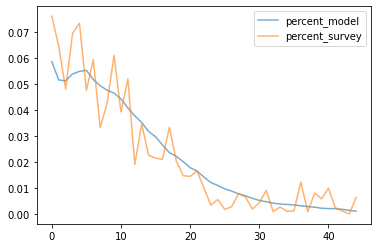

In [12]:
if len(_df_survey) > 0:
    _df_merged[['percent_model','percent_survey']].plot(alpha=0.6)
else:
    _df[['percent']].plot(alpha=0.6)

# Average Trip Distance
Workers that work DO NOT work from home

In [13]:
# Non WFH Workers
df = pd.read_csv(os.path.join(working_dir,'trip_distance_non_wfh.csv'))
df = df[df['pptyp'].isin(['Full-Time Worker','Part-Time Worker'])]
df = df[(df['dpurp'] == 'Work') & (df['dadtyp'].isin(['Other','Usual Workplace']))]
# df.groupby(['travdist_bin','']).sum()[['trexpfac']]
df_usual = df[df['dadtyp'] == 'Usual Workplace']
dist = (df_usual['trexpfac']*1.0*df_usual['travdist_bin']).sum()/df_usual['trexpfac'].sum()
print('Avg. distance to Usual Workplace: ' + str(dist))
df_other = df[df['dadtyp'] == 'Other']
dist = (df_other['trexpfac']*1.0*df_other['travdist_bin']).sum()/df_other['trexpfac'].sum()
print('Avg. distance to Other Workplace: ' + str(dist))
print('----------------------------------------')
# Non WFH Workers
df = pd.read_csv(os.path.join(working_dir,'trip_distance_non_wfh.csv'))
df['wt_sum'] = df['trexpfac']*1.0*df['travdist_bin']
result = {}
for purp in pd.unique(df['dpurp']):
    _df = df[df['dpurp'] == purp]
    result[purp] = _df['wt_sum'].sum()/_df['trexpfac'].sum()
    
_df_non_wfh = pd.DataFrame.from_dict(result, orient='index').reset_index()
_df_non_wfh.columns = ['Purpose','Workers at Non-Home Location']
_df_non_wfh

Avg. distance to Usual Workplace: 8.322181502417273
Avg. distance to Other Workplace: 4.70911939513441
----------------------------------------


,Purpose,Workers at Non-Home Location
0,None/Home,5.0615
1,Work,7.1618
2,School,2.4313
3,Escort,4.6686
4,Personal Business,4.4728
5,Shop,3.5762
6,Meal,4.7140
7,Social,3.8665
8,Change Mode Inserted Purpose,8.5579


Only workers that work **from home**

In [14]:
# WFH Workers
df = pd.read_csv(os.path.join(working_dir,'trip_distance_wfh.csv'))
df = df[(df['dpurp'] == 'Work') & (df['dadtyp'].isin(['Other','Usual Workplace']))]

df_other = df[df['dadtyp'] == 'Other']
dist = (df_other['trexpfac']*1.0*df_other['travdist_bin']).sum()/df_other['trexpfac'].sum()
print('Avg. distance to Other Workplace: ' + str(dist))
print('----------------------------------')
df = pd.read_csv(os.path.join(working_dir,'trip_distance_wfh.csv'))
df['wt_sum'] = df['trexpfac']*1.0*df['travdist_bin']
result = {}
for purp in pd.unique(df['dpurp']):
    _df = df[df['dpurp'] == purp]
    result[purp] = _df['wt_sum'].sum()/_df['trexpfac'].sum()

_df_wfh = pd.DataFrame.from_dict(result, orient='index')
_df_wfh = _df_wfh.reset_index()
_df_wfh.columns = ['Purpose','WFH Workers']
_df_wfh

Avg. distance to Other Workplace: 11.524316109422493
----------------------------------


,Purpose,WFH Workers
0,None/Home,2.3876
1,Work,11.5243
2,School,3.6816
3,Escort,2.2596
4,Personal Business,1.8629
5,Shop,1.7331
6,Meal,2.5355
7,Social,1.8817
8,Change Mode Inserted Purpose,12.2222


In [15]:
# Non-Workers
df = pd.read_csv(os.path.join(working_dir,'trip_distance_non_wfh.csv'))
df = df[-df['pptyp'].isin(['Full-Time Worker','Part-Time Worker'])]
df = df[(df['dpurp'] == 'Work') & (df['dadtyp'].isin(['Other','Usual Workplace']))]

# Non-Workers
df = pd.read_csv(os.path.join(working_dir,'trip_distance_non_wfh.csv'))
df['wt_sum'] = df['trexpfac']*1.0*df['travdist_bin']
result = {}
for purp in pd.unique(df['dpurp']):
    _df = df[df['dpurp'] == purp]
    result[purp] = _df['wt_sum'].sum()/_df['trexpfac'].sum()
    
_df_non_worker = pd.DataFrame.from_dict(result, orient='index')
_df_non_worker = _df_non_worker.reset_index()
_df_non_worker.columns = ['Purpose','Non-Workers']
_df_non_worker

,Purpose,Non-Workers
0,None/Home,5.0615
1,Work,7.1618
2,School,2.4313
3,Escort,4.6686
4,Personal Business,4.4728
5,Shop,3.5762
6,Meal,4.7140
7,Social,3.8665
8,Change Mode Inserted Purpose,8.5579


Average Trip Distance by Purpose and Worker/Person Type

In [16]:
_df = pd.merge(_df_non_wfh, _df_wfh).merge(_df_non_worker)

In [17]:
_df

,Purpose,Workers at Non-Home Location,WFH Workers,Non-Workers
0,None/Home,5.0615,2.3876,5.0615
1,Work,7.1618,11.5243,7.1618
2,School,2.4313,3.6816,2.4313
3,Escort,4.6686,2.2596,4.6686
4,Personal Business,4.4728,1.8629,4.4728
5,Shop,3.5762,1.7331,3.5762
6,Meal,4.7140,2.5355,4.7140
7,Social,3.8665,1.8817,3.8665
8,Change Mode Inserted Purpose,8.5579,12.2222,8.5579


# VMT

Workers that Work from Home

In [18]:
df = pd.read_csv(os.path.join(working_dir,'vmt_wfh.csv'))
df_survey = pd.read_csv(os.path.join(working_dir,'survey','vmt_wfh.csv'))

pd.options.display.float_format = '{:,.2f}'.format
_df = df[(df['mode'].isin(['SOV','HOV2','HOV3+']))&
   (df['dorp']==1) &
   (df['pptyp'].isin(['Full-Time Worker','Part-Time Worker']))].groupby('dpurp').sum()[['travdist_wt']]
_df['VMT per Person (Model)'] = _df['travdist_wt']/total_wfh_workers

_df_survey = df_survey[(df_survey['mode'].isin(['SOV','HOV2','HOV3+']))&
   (df_survey['dorp']==1) &
   (df_survey['pptyp'].isin(['Full-Time Worker','Part-Time Worker']))].groupby('dpurp').sum()[['travdist_wt']]
_df_survey['VMT per Person (Model)'] = _df_survey['travdist_wt']/total_wfh_workers_survey

_df = _df.merge(_df_survey, left_index=True, right_index=True, suffixes=['_model','_survey'])
_df.loc['Total',:] = _df.sum()
_df[['travdist_wt_model','travdist_wt_survey']] = _df[['travdist_wt_model','travdist_wt_survey']].astype('int')
_df.rename(columns={'travdist_wt_model': 'Total VMT (Model)', 'travidst_wt_survey': 'Total VMT (Survey)'},
                   inplace=True)
_df

,Total VMT (Model),VMT per Person (Model)_model,travdist_wt_survey,VMT per Person (Model)_survey
dpurp,,,,
Escort,190349,0.62,324337,1.05
Meal,282851,0.91,86959,0.28
None/Home,663400,2.14,1020756,3.30
Personal Business,68144,0.22,197833,0.64
School,550,0.00,8538,0.03
Shop,167461,0.54,250075,0.81
Social,297820,0.96,330934,1.07
Work,13135,0.04,464829,1.50
Total,1683712,5.44,2684264,8.68


Workers that do NOT Work from Home

In [19]:
df = pd.read_csv(os.path.join(working_dir,'vmt_nonwfh.csv'))
df_survey = pd.read_csv(os.path.join(working_dir,'survey','vmt_nonwfh.csv'))

pd.options.display.float_format = '{:,.2f}'.format
_df = df[(df['mode'].isin(['SOV','HOV2','HOV3+']))&
   (df['dorp']==1) &
   (df['pptyp'].isin(['Full-Time Worker','Part-Time Worker']))].groupby('dpurp').sum()[['travdist_wt']]
_df['VMT per Person (Model)'] = _df['travdist_wt']/total_nonwfh_workers

_df_survey = df_survey[(df_survey['mode'].isin(['SOV','HOV2','HOV3+']))&
   (df_survey['dorp']==1) &
   (df_survey['pptyp'].isin(['Full-Time Worker','Part-Time Worker']))].groupby('dpurp').sum()[['travdist_wt']]
_df_survey['VMT per Person (Model)'] = _df_survey['travdist_wt']/total_nonwfh_workers_survey

_df = _df.merge(_df_survey, left_index=True, right_index=True, suffixes=['_model','_survey'])
_df.loc['Total',:] = _df.sum()
_df[['travdist_wt_model','travdist_wt_survey']] = _df[['travdist_wt_model','travdist_wt_survey']].astype('int')
_df.rename(columns={'travdist_wt_model': 'Total VMT (Model)', 'travidst_wt_survey': 'Total VMT (Survey)'},
                   inplace=True)
_df

,Total VMT (Model),VMT per Person (Model)_model,travdist_wt_survey,VMT per Person (Model)_survey
dpurp,,,,
Escort,4345742,1.99,2118230,1.02
Meal,2207069,1.01,1208266,0.58
None/Home,12399465,5.68,12764537,6.16
Personal Business,1241817,0.57,1207875,0.58
School,14220,0.01,116126,0.06
Shop,2206830,1.01,2249325,1.09
Social,2841208,1.30,3296415,1.59
Work,15596890,7.15,14607165,7.05
Total,40853244,18.72,37567942,18.13
